## Section 8. Model Evaluation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

## 문제 1. ROC Curve 와 AUC 구하기

아래 코드는 
IRIS 데이터 셋을 이용해  Iris Versicolour 와 Iris Virginica 을 구별하는 코드 입니다. 

아래 코드를 수행 했을 때 나온 데이터프레임에는 각 데이터 별로 예측값과 정답값에 대한 정보가 담겨져 있습니다. 이를 이용해 **ROC Curve** 와 **AUC** 을 구하고 시각화 합니다. 

참고 
- 음성 label 은 0 , Versicolour <br>
- 양성 label 은 1 , Virginica 입니다. 

In [0]:
# 우선 실행해주세요
np.random.seed(1) # 같은 결과를 보장하기 위함
# load Iris dataset 
iris = load_iris()

indices = np.where((iris['target'] == 1) | (iris['target'] == 2))

data = iris['data'][indices]
target = iris['target'][indices]
target = np.where(target==1, 0, 1)
target = target.reshape([-1, 1])
target_name = iris['target_names']

In [0]:
# Normalization
data_norm = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))

# Xs 와 np.ones 을 concatenate for broadcasting  
feature = np.concatenate([data_norm, np.ones(shape=[data_norm.shape[0], 1])], axis=1)

In [0]:
import tensorflow as tf

In [0]:
def sigmoid(x):
    return 1 / (1 + tf.exp(-x))

In [0]:
# Build graph

# 'input' is a reserved word
xs = tf.placeholder(dtype=tf.float32, shape=feature.shape)

ys = tf.placeholder(dtype=tf.float32, shape=target.shape)

ws_shape = (feature.shape[-1], 1)
ws = tf.Variable(dtype=tf.float32, \
                     initial_value=tf.ones(shape=ws_shape))

logit = tf.matmul(xs, ws)
pred = sigmoid(logit)
diff = pred - ys
gradient = tf.matmul(tf.transpose(xs), diff)

lr = tf.placeholder_with_default(0.01, shape=[])
step = tf.assign_sub(ws, lr * gradient)

In [0]:
ys_bool = tf.cast(ys, tf.bool)

cut_value = tf.placeholder(tf.float32, [], name='cut_value')
yhats_bool = pred > cut_value

In [0]:
tp = ys_bool & yhats_bool
fn = ys_bool & ~yhats_bool

fp = ~ys_bool & yhats_bool
tn = ~ys_bool & ~yhats_bool

In [0]:
l = [tp, fn, fp, tn]
l = [tf.reduce_sum(tf.cast(e, tf.float32)) for e in l]

In [0]:
tp, fn, fp, tn = l

recall = tp/(tp+fn)
fallout = fp/(fp+tn)

In [0]:
sess = tf.Session(graph=tf.get_default_graph())
sess.run(tf.global_variables_initializer())

In [12]:
# Train
steps = 100
fetches = step
feeds = {xs: feature, ys: target, cut_value: 0.5}
for i in range(steps):
    _, confusion_matrix = sess.run([step, l], feed_dict=feeds)
    
    if i % 10 == 0:
        print('==== step {} ===='.format(i))
        print('[tp, fn, fp, tn]')
        print(confusion_matrix)

==== step 0 ====
[tp, fn, fp, tn]
[50.0, 0.0, 50.0, 0.0]
==== step 10 ====
[tp, fn, fp, tn]
[48.0, 2.0, 14.0, 36.0]
==== step 20 ====
[tp, fn, fp, tn]
[48.0, 2.0, 6.0, 44.0]
==== step 30 ====
[tp, fn, fp, tn]
[46.0, 4.0, 5.0, 45.0]
==== step 40 ====
[tp, fn, fp, tn]
[46.0, 4.0, 3.0, 47.0]
==== step 50 ====
[tp, fn, fp, tn]
[46.0, 4.0, 3.0, 47.0]
==== step 60 ====
[tp, fn, fp, tn]
[46.0, 4.0, 3.0, 47.0]
==== step 70 ====
[tp, fn, fp, tn]
[46.0, 4.0, 3.0, 47.0]
==== step 80 ====
[tp, fn, fp, tn]
[46.0, 4.0, 3.0, 47.0]
==== step 90 ====
[tp, fn, fp, tn]
[46.0, 4.0, 3.0, 47.0]


In [0]:
tprs = []
fprs = []

for v in np.arange(0, 1.1, 0.001):
    feeds[cut_value] = v
    tpr, fpr = sess.run([recall, fallout], feed_dict=feeds)
    tprs.append(tpr)
    fprs.append(fpr)

In [0]:
def get_auc(xs, ys):
    fprs, tprs = xs, ys
    prev_fpr = fprs[0]
    prev_tpr = tprs[0]
    
    auc = 0
    for fpr, tpr in zip(fprs[1:], tprs[1:]):
        segment = (prev_fpr-fpr)*(prev_tpr+tpr)/2
        auc += segment
        prev_fpr, prev_tpr = fpr, tpr
    
    return auc

Text(0.5, 0.5, '0.9944')

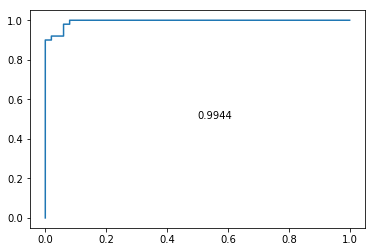

In [15]:
plt.plot(fprs, tprs)
plt.text(0.5, 0.5, '{:.4f}'.format(get_auc(fprs, tprs)))

#### 정답 확인

정답 : AUC , ROC curve 는 아래와 같은 그림이 나와야 정답입니다

![Imgur](https://i.imgur.com/nOOc7Va.png)